In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 

# Pytorch
import torch 
from torch.utils.data import Subset, DataLoader

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SDLoss import physics_loss
from Preprocessing import random_spatial_sequence, collate_fn

# Plot
import matplotlib.pyplot as plt

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'test_ratio': 0,
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
smid_list = sorted([1,2,4,5,6,10,11,12,16,18,22,25,33,35,37,42,40,52,54,27,55,53,32,31,30])
print(smid_list)
print(len(smid_list), 'of in-situ')

[1, 2, 4, 5, 6, 10, 11, 12, 16, 18, 22, 25, 27, 30, 31, 32, 33, 35, 37, 40, 42, 52, 53, 54, 55]
25 of in-situ


In [6]:
ati_root = os.path.join(config['root'], "LABEL\\ATI")
time_list = sorted(os.listdir(ati_root))
print(time_list)

['2015104', '2015106', '2015114', '2015115', '2015117', '2015130', '2015131', '2015136', '2015138', '2015149', '2015160', '2015162', '2015165', '2015171', '2015176', '2015186', '2015187', '2015194', '2015195', '2015200', '2015202', '2015203', '2015205', '2015208', '2015211', '2015213', '2015216', '2015221', '2015226', '2015229', '2015232', '2015234', '2015235', '2015258', '2015259', '2015267', '2015272', '2015275', '2015277', '2015280', '2015282', '2015283', '2015285', '2015288', '2015290', '2015291', '2015296', '2015330', '2015333']


In [7]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
 
def linear_func(X, Y):
    #转换成numpy的ndarray数据格式，n行1列,LinearRegression需要列格式数据，如下：
    X_train = np.array(X).reshape((len(X), 1))
    Y_train = np.array(Y).reshape((len(Y), 1))
 
    #新建一个线性回归模型，并把数据放进去对模型进行训练
    lineModel = LinearRegression()
    lineModel.fit(X_train, Y_train)
 
    #用训练后的模型，进行预测
    Y_predict = lineModel.predict(X_train)
    
    return lineModel

y=0.3448*x+0.3750
得分 0.017000414427973065


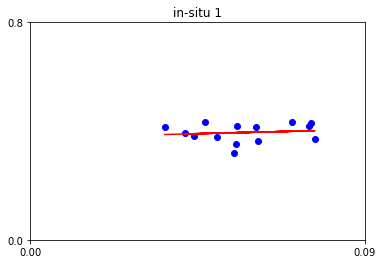

y=2.9023*x+0.1869
得分 0.32220183159549487


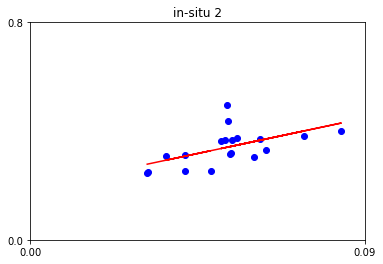

y=3.4178*x+0.0010
得分 0.3969350771940511


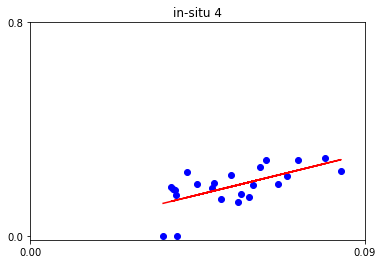

y=6.4151*x+0.0991
得分 0.3202717387414835


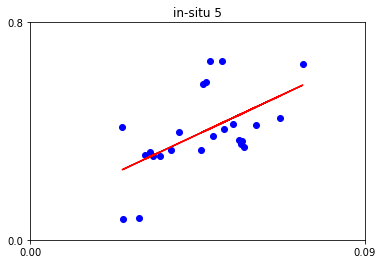

y=8.4238*x+-0.2731
得分 0.6540267799575773


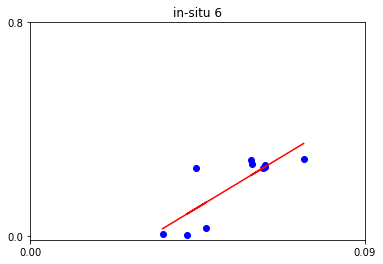

y=2.5712*x+0.2396
得分 0.22013003733799752


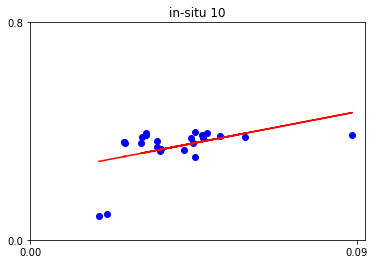

y=4.7109*x+0.1621
得分 0.29231221022798903


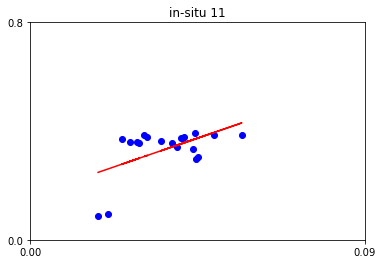

y=2.7119*x+0.2904
得分 0.0542947496614945


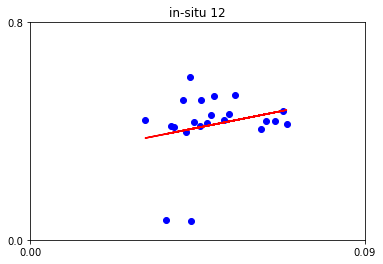

y=4.2638*x+0.0853
得分 0.28903395512881647


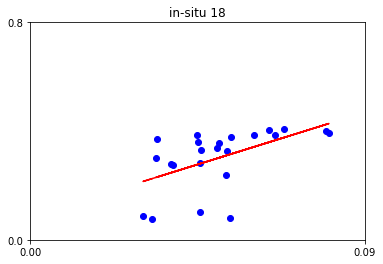

y=1.2677*x+0.1200
得分 0.1434965103678547


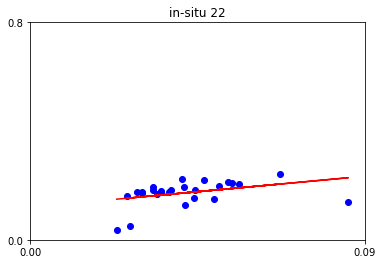

y=2.4953*x+0.1652
得分 0.0740173568756275


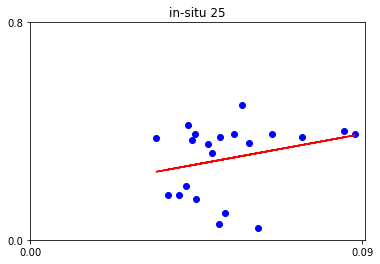

y=4.1233*x+0.0854
得分 0.505513310064884


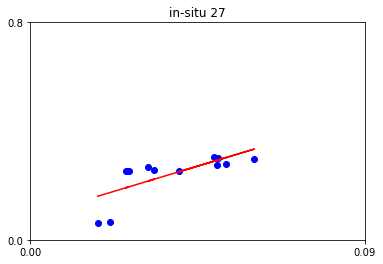

y=1.8130*x+0.0704
得分 0.15122322739849647


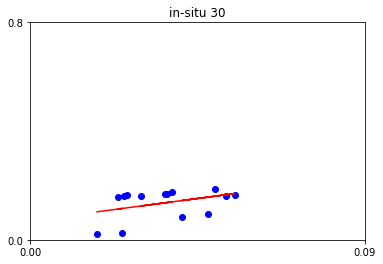

y=1.9958*x+0.1689
得分 0.2065469335971023


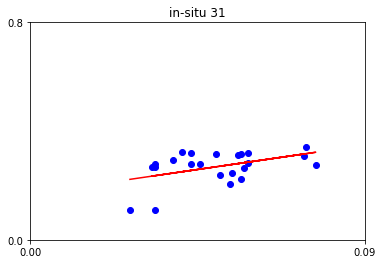

y=2.8038*x+0.0492
得分 0.5594063112800677


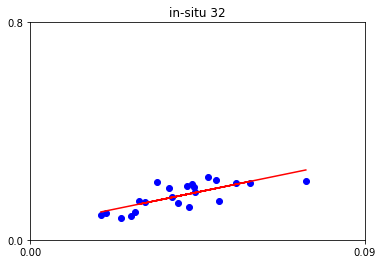

y=4.1778*x+0.0099
得分 0.11056114860881994


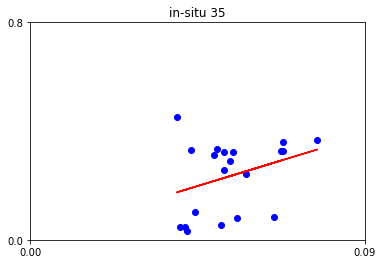

y=2.6512*x+0.0076
得分 0.5422324995603693


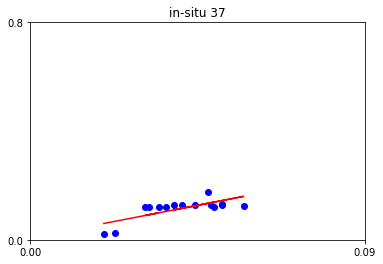

y=1.1778*x+0.4075
得分 0.35211440827452967


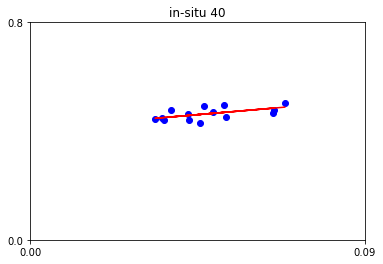

y=3.5262*x+0.1716
得分 0.3896800757966017


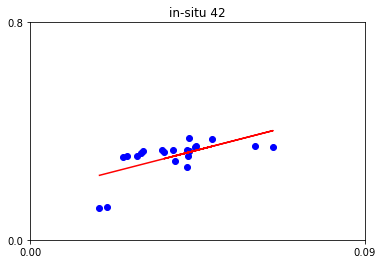

y=3.0729*x+0.1263
得分 0.1787351750254389


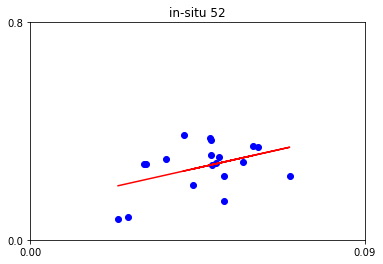

y=-0.0085*x+0.6844
得分 0.00010664016312444957


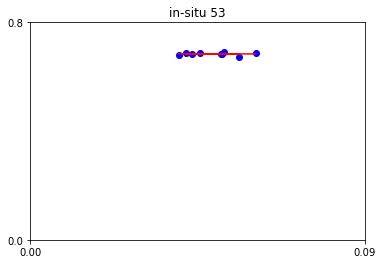

y=3.5713*x+0.0494
得分 0.4297086798833061


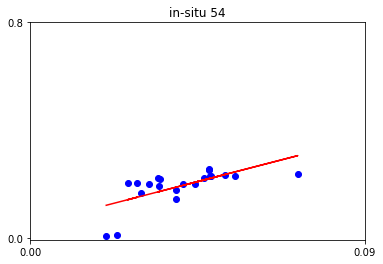

y=2.0479*x+0.1175
得分 0.299960967349879


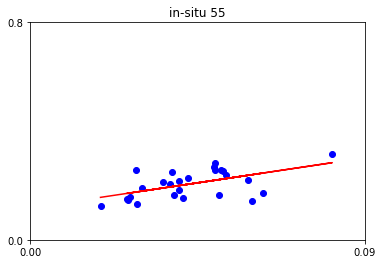

In [16]:
score_list = []
a_list = []
b_list = []
id_list = []
for smid in smid_list:
    ati_list = []
    sm_list = []
    for day in time_list:
        ati_path = os.path.join(config['root'], 'LABEL\\ATI\\{}\\{}.npy'.format(day, smid))
        sm_path = os.path.join(config['root'], 'LABEL\\SM\\{}\\{}.npy'.format(day, smid))
        
        if os.path.exists(ati_path) and np.load(sm_path, allow_pickle=True)[0]!=0:
            if np.load(ati_path, allow_pickle=True)[0]<0.09:
                ati_list.append(np.load(ati_path, allow_pickle=True)[0])
                sm_list.append(np.load(sm_path, allow_pickle=True)[0])
    if len(ati_list)<3:
        continue
    
    #转换成numpy的ndarray数据格式，n行1列,LinearRegression需要列格式数据，如下：
    X_train = np.array(ati_list).reshape((len(ati_list), 1))
    Y_train = np.array(sm_list).reshape((len(sm_list), 1))
 
    #新建一个线性回归模型，并把数据放进去对模型进行训练
    lineModel = LinearRegression()
    lineModel.fit(X_train, Y_train)
 
    #用训练后的模型，进行预测
    Y_predict = lineModel.predict(X_train)
    #coef_是系数，intercept_是截距
    a1 = lineModel.coef_[0][0]
    b = lineModel.intercept_[0]
    print("y=%.4f*x+%.4f" % (a1,b))
 
    #对回归模型进行评分，这里简单使用训练集进行评分，实际很多时候用其他的测试集进行评分
    print("得分", lineModel.score(X_train, Y_train))
 
    #简单画图显示
    plt.scatter(ati_list, sm_list, c="blue")
    plt.plot(X_train,Y_predict, c="red")
    plt.xticks([0, 0.09])
    plt.yticks([0, 0.8])
    plt.title('in-situ {}'.format(smid))
    plt.show()
    if lineModel.score(X_train, Y_train)>0.1:
        score_list.append(lineModel.score(X_train, Y_train))
        a_list.append(a1)
        b_list.append(b)
        id_list.append(smid)

In [17]:
print(np.mean(score_list))

0.3349521514416189


In [18]:
print(id_list)
print(score_list)

[2, 4, 5, 6, 10, 11, 18, 22, 27, 30, 31, 32, 35, 37, 40, 42, 52, 54, 55]
[0.32220183159549487, 0.3969350771940511, 0.3202717387414835, 0.6540267799575773, 0.22013003733799752, 0.29231221022798903, 0.28903395512881647, 0.1434965103678547, 0.505513310064884, 0.15122322739849647, 0.2065469335971023, 0.5594063112800677, 0.11056114860881994, 0.5422324995603693, 0.35211440827452967, 0.3896800757966017, 0.1787351750254389, 0.4297086798833061, 0.299960967349879]


In [19]:
texture_root = os.path.join('\INPUT\TEXTURE')
for smid in id_list:
    

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_4304/467064206.py, line 3)

# Training

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=2, oob_score=False)
rf.fit(X_train, train_sd_list)
train_accuracy = rf.score(X_train, train_sd_list)
print(train_accuracy)

NameError: name 'train_sd_list' is not defined

# Testing

In [ ]:
y_pred = rf.predict(X_test)
accuracy = rf.score(X_test, test_sd_list)
print(accuracy)
print(y_pred)